In [1]:
from IPython.display import clear_output

!pip install -q tensorflow==2.4.1

clear_output()

In [2]:
import tensorflow as tf
tf.__version__

2022-09-20 01:38:35.164342: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


'2.4.1'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [4]:
# Check the GPU
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-dbd0687c-4685-f899-d9bc-8100bbf6a33d)


In [5]:
# Setting up the directories
train_dir = '/kaggle/input/gravity-spy-gravitational-waves/train/train/'
validation_dir = '/kaggle/input/gravity-spy-gravitational-waves/validation/validation/'
test_dir = '/kaggle/input/gravity-spy-gravitational-waves/test/test/'

In [6]:
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=32)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                                     label_mode='categorical',
                                                                     image_size=IMG_SIZE,
                                                                     batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=32,
                                                               shuffle=False)

Found 22348 files belonging to 22 classes.


2022-09-20 01:39:10.931130: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-20 01:39:10.932552: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-20 01:39:10.988477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 01:39:10.990545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-09-20 01:39:10.990644: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-09-20 01:39:11.022784: I tensorflow/stream_executor/platform/def

Found 4800 files belonging to 22 classes.
Found 4720 files belonging to 22 classes.


# Explore the training dataset

In [7]:
# Check the train_data
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 22)), types: (tf.float32, tf.float32)>

So this is a BatchDataset in a tuple data structure. The first index refers to batches of images with shape (224, 224, 3) where last index refers to the number of color channels. The second index refers to the total number of labels present i.e. 22.

In [8]:
# Get the class names
class_names = train_data.class_names
class_names[:4]

['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip']

In [9]:
# Check the number of class names
len(class_names)

22

In [10]:
# # Can run this cell but there is some unresolved issue. Will look at it later
# for image, label in train_data.take(1):
#     print(image, label)

In [11]:
# Let's visualize some images from training data set
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_random_image(target_dir=train_dir, 
                      target_class=None,
                      num_imgs=4):
    target_dir = target_dir + target_class
    random_image = random.sample(os.listdir(target_dir), num_imgs)
    idx = int(np.sqrt(num_imgs))
    fig, axs = plt.subplots(idx, idx, figsize=(8, 8))
    for i in range(idx):
        for j in range(idx):
            random_image_dir = target_dir + "/" + random_image[i]
            img = mpimg.imread(random_image_dir)
            axs[i, j].imshow(img)
            axs[i, j].axis(False)
            axs[i, j].set_title(target_class)

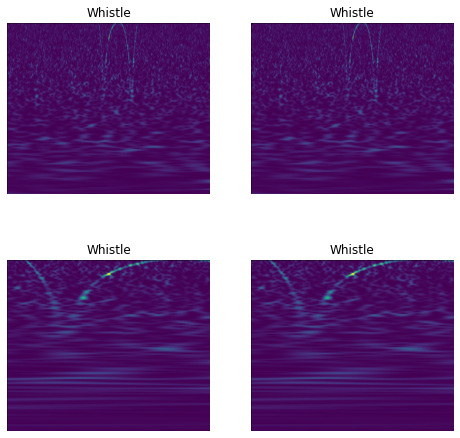

In [12]:
# change the class_names to visualize different training images
view_random_image(train_dir,
                 class_names[21])

# Creating callbacks

In [13]:
# ModelCheckpoint callback: saves the weight of the best training epoch
checkpoint_path = '/kaggle/gw_feature_extraction/cp.ckpt'
modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                             save_weights_only=True,
                                                             save_best_only=True,
                                                             monitor="val_accuracy")


In [14]:
# Create a TensorBoard callback: visualize different experiments on TensorBoard
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [15]:
# Create EarlyStopping callback: stops model training once the monitor metric stops improving for given patience (epochs)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", # watch the val loss metric
                                                          patience=3)

In [16]:
reducelr_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2,
                                                        monitor='val_accuracy',
                                                        min_lr=1e-7,
                                                        patience=0,
                                                        verbose=1)

# Feature extraction model using ResNet50V2

Since we are using Resnet50, which does not have rescaling layer built in, we are going to create a rescaling layer and then pass that layer into our model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

# Rescaling layer
image_rescaling = Sequential([
    preprocessing.Rescaling(1/255.)
], name='rescaling_layer')

In [18]:
from tensorflow.keras import layers

# Base model ResNet50V2
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = image_rescaling(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='GAP2D')(x)
outputs = layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)

94674944/94668760 [==============================] - 1s 0us/step


In [19]:
# Model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_layer (Sequential) (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, None, None, 2048)  23564800  
_________________________________________________________________
GAP2D (GlobalAveragePooling2 (None, 2048)              0         
_________________________________________________________________
output_layer (Dense)         (None, 22)                45078     
Total params: 23,609,878
Trainable params: 45,078
Non-trainable params: 23,564,800
_________________________________________________________________


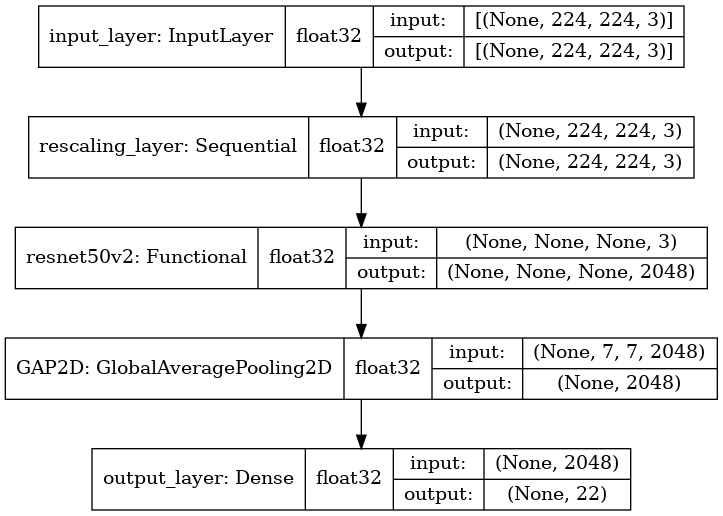

In [20]:
# Plot the model
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_dtype=True)

In [21]:
# Compile the model
model.compile(loss=tf.keras.losses.categorical_crossentropy,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

history_feature_extract = model.fit(train_data,
                                    epochs=100,
                                   steps_per_epoch=len(train_data),
                                   validation_data=validation_data,
                                   validation_steps=int(0.15 * len(validation_data)),
                                   callbacks=[create_tensorboard_callback("/kaggle/training_logs",
                                                                         "resnet50v2_feature_extract"),
                                              modelcheckpoint_callback,
                                             earlystopping_callback,
                                             reducelr_callback])

2022-09-20 01:39:42.506833: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-09-20 01:39:42.506881: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-09-20 01:39:42.506951: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2022-09-20 01:39:42.527635: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.11.0
2022-09-20 01:39:42.706544: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-09-20 01:39:42.706725: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


Saving TensorBoard log files to: /kaggle/training_logs/resnet50v2_feature_extract/20220920-013942
Epoch 1/100


2022-09-20 01:39:45.417548: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-20 01:39:45.434735: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000150000 Hz
2022-09-20 01:39:45.780759: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-09-20 01:39:46.660603: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-09-20 01:39:50.070881: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


  1/699 [..............................] - ETA: 2:42:55 - loss: 3.1890 - accuracy: 0.0312

2022-09-20 01:39:57.010230: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-09-20 01:39:57.010292: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


  2/699 [..............................] - ETA: 12:55 - loss: 3.1709 - accuracy: 0.0391  

2022-09-20 01:39:58.036327: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-09-20 01:39:58.036852: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2022-09-20 01:39:58.172790: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 355 callback api events and 343 activity events. 
2022-09-20 01:39:58.181513: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-09-20 01:39:58.194060: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /kaggle/training_logs/resnet50v2_feature_extract/20220920-013942/train/plugins/profile/2022_09_20_01_39_58
2022-09-20 01:39:58.203049: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /kaggle/training_logs/resnet50v2_feature_extract/20220920-013942/train/plugins/profile/2022_09_20_01_39_58/219a84264cbc.trace.json.gz
202

699/699 [==============================] - 403s 557ms/step - loss: 1.1283 - accuracy: 0.6930 - val_loss: 0.5476 - val_accuracy: 0.8423
Epoch 2/100
699/699 [==============================] - 219s 310ms/step - loss: 0.4311 - accuracy: 0.8853 - val_loss: 0.4633 - val_accuracy: 0.8807
Epoch 3/100
699/699 [==============================] - 216s 305ms/step - loss: 0.3339 - accuracy: 0.9094 - val_loss: 0.4105 - val_accuracy: 0.8864
Epoch 4/100
699/699 [==============================] - 215s 305ms/step - loss: 0.2852 - accuracy: 0.9231 - val_loss: 0.3667 - val_accuracy: 0.9048
Epoch 5/100
699/699 [==============================] - 217s 308ms/step - loss: 0.2496 - accuracy: 0.9326 - val_loss: 0.3390 - val_accuracy: 0.9119
Epoch 6/100
699/699 [==============================] - 218s 308ms/step - loss: 0.2231 - accuracy: 0.9395 - val_loss: 0.3307 - val_accuracy: 0.9105

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 7/100
699/699 [===========================

In [23]:
# Save the model
model.save("glitch_feature_extract.h5")

In [24]:
import matplotlib.pyplot as plt

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    fig, axs = plt.subplots(1, 2, sharex=True, squeeze=True, figsize=(12, 6))
    axs[0].plot(epochs, loss, label='loss')
    axs[0].plot(epochs, val_loss, label='val_loss')
    axs[0].set_title('loss')
    axs[0].set_xlabel('epochs')
    axs[0].legend()

    axs[1].plot(epochs, accuracy, label='accuracy')
    axs[1].plot(epochs, val_accuracy, label='val_accuracy')
    axs[1].set_title('accuracy')
    axs[1].set_xlabel('epochs')
  

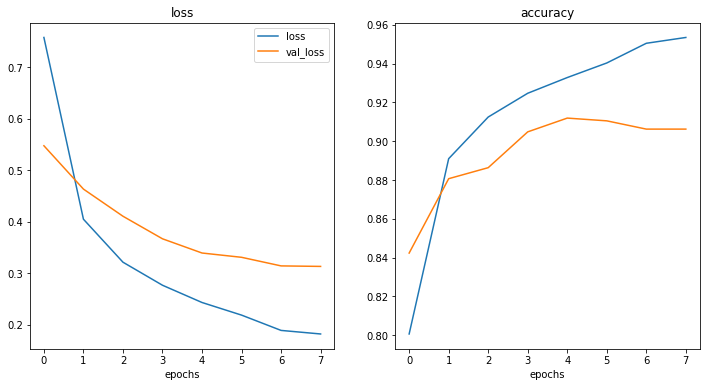

In [25]:
# Plot the loss curves

plot_history(history_feature_extract)

In [26]:
# Evaluate the model
model.evaluate(test_data)

148/148 [==============================] - 78s 527ms/step - loss: 0.2893 - accuracy: 0.9189


[0.28926390409469604, 0.9188559055328369]

In [37]:
!ls -altr

total 92956
---------- 1 root root      263 Sep 20 01:36 __notebook_source__.ipynb
drwxr-xr-x 2 root root     4096 Sep 20 01:37 .virtual_documents
-rw-r--r-- 1 root root    54553 Sep 20 01:39 model.png
drwxr-xr-x 7 root root     4096 Sep 20 01:46 ..
-rw-r--r-- 1 root root 95111672 Sep 20 02:12 glitch_feature_extract.h5
drwxr-xr-x 3 root root     4096 Sep 20 02:17 .


In [30]:
# # Saving the whole directory as zip
# import shutil
# shutil.make_archive("glitch_classification_advanced_LIGO", 'zip', "/kaggle/working")

In [39]:
filepath = "/kaggle/working"
loaded_model = tf.keras.models.load_model(filepath+"/glitch_feature_extract.h5")
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_layer (Sequential) (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, None, None, 2048)  23564800  
_________________________________________________________________
GAP2D (GlobalAveragePooling2 (None, 2048)              0         
_________________________________________________________________
output_layer (Dense)         (None, 22)                45078     
Total params: 23,609,878
Trainable params: 45,078
Non-trainable params: 23,564,800
_________________________________________________________________


In [40]:
loaded_model.evaluate(test_data)

148/148 [==============================] - 61s 408ms/step - loss: 0.2893 - accuracy: 0.9189


[0.28926390409469604, 0.9188559055328369]

# Evaluating the model

In [104]:
# Get the prediction probability of model
pred_prob = model.predict(test_data, verbose=1)
pred_prob[:5]

148/148 [==============================] - 45s 302ms/step


array([[2.6712120e-01, 3.2803486e-04, 3.5342231e-02, 3.3442648e-03,
        7.0856707e-08, 5.8148179e-04, 6.3445687e-04, 1.7694903e-07,
        9.4571300e-03, 1.4356490e-02, 2.2305299e-02, 2.8960020e-03,
        6.7126397e-03, 1.5653869e-03, 4.9659401e-01, 9.4370614e-04,
        7.1466736e-02, 6.8990141e-03, 5.3038944e-05, 5.0216589e-02,
        4.4227648e-03, 4.7593182e-03],
       [8.7648046e-01, 5.6736162e-03, 1.5531060e-02, 2.7414539e-04,
        2.2888136e-09, 3.2183805e-06, 1.0809147e-03, 2.9038315e-08,
        2.3467463e-04, 6.3161771e-03, 8.0720447e-03, 4.2414963e-03,
        1.5287687e-03, 9.8039432e-05, 3.6522161e-02, 1.7981157e-04,
        1.7660693e-03, 4.3228877e-04, 1.1795383e-05, 3.6222328e-02,
        3.7094683e-03, 1.6214007e-03],
       [6.5691680e-01, 5.6279488e-03, 9.3129883e-03, 4.4239534e-04,
        2.4118538e-09, 4.2052207e-07, 2.3444630e-04, 2.8815517e-08,
        9.7472119e-05, 1.4224174e-02, 2.5442441e-03, 6.8912923e-04,
        4.8027514e-04, 5.1301678e-05, 

In [105]:
pred_prob.shape

(4720, 22)

In [106]:
# Get the classes predicted by the model for the test dataset
pred_class = pred_prob.argmax(axis=1)
pred_class[-10:], pred_class.shape

(array([21, 21, 21, 21, 21, 21, 21, 21, 21, 21]), (4720,))

In [107]:
# Get the true labels of the test dataset
true_class = []
for images, labels in test_data.unbatch():
    true_class.append(labels.numpy().argmax())
true_class[-10:], len(true_class)

([21, 21, 21, 21, 21, 21, 21, 21, 21, 21], 4720)

In [108]:
# sklearn accuracy (should be equal to tensorflow evaluation)
from sklearn.metrics import accuracy_score
sklearn_score = accuracy_score(true_class, pred_class)
sklearn_score

0.9188559322033898

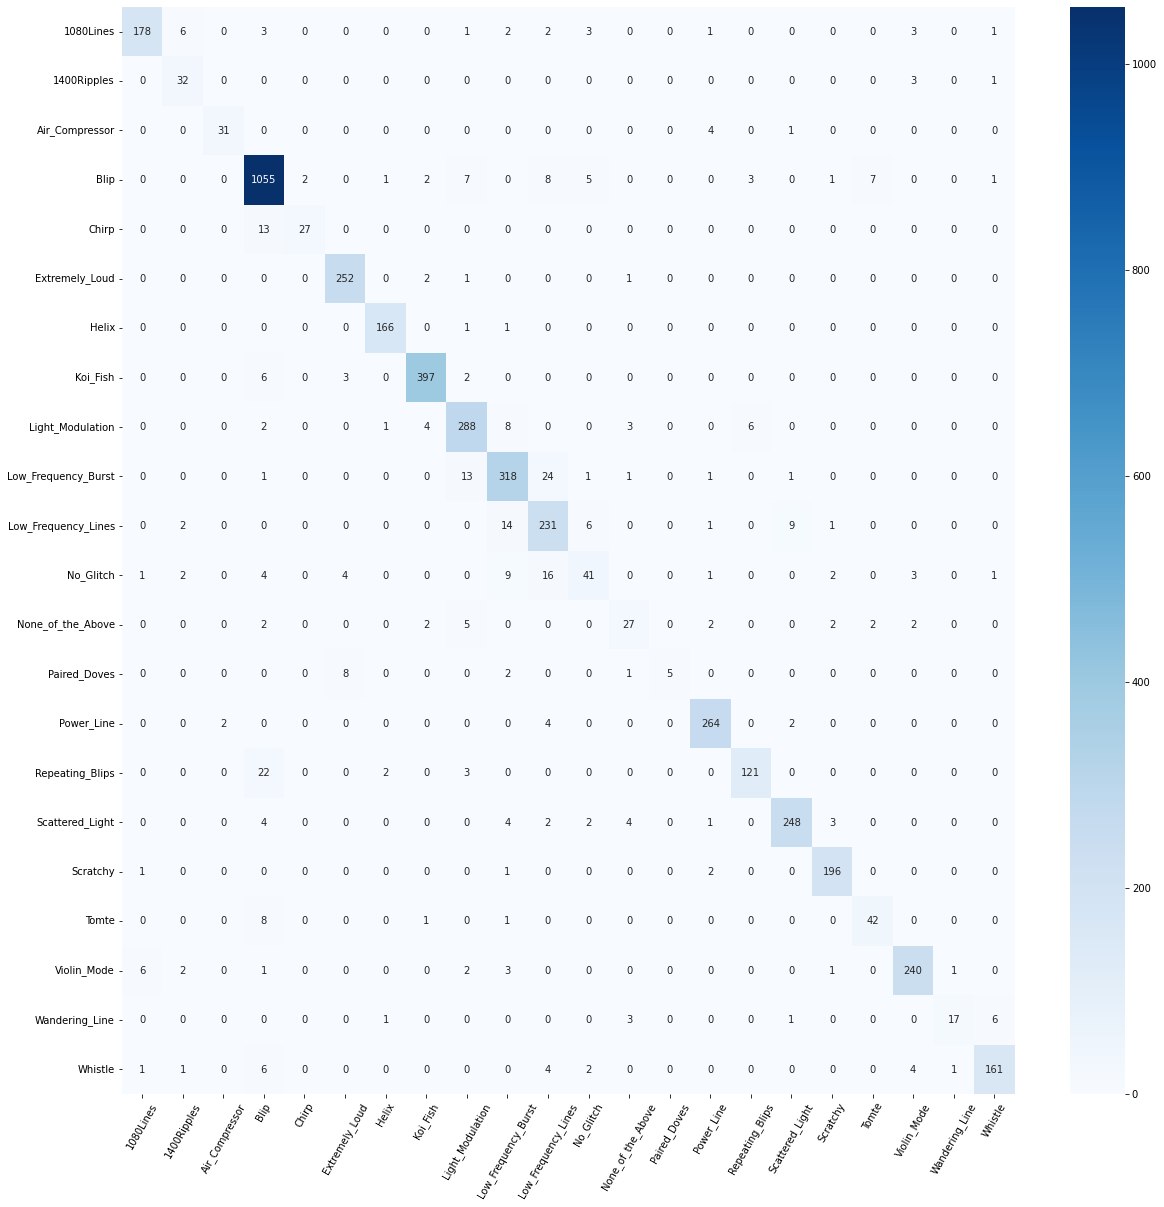

In [109]:
# Create the confusion matrix
from tensorflow.math import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(true_class, pred_class)

plt.figure(figsize=(20, 20))

x_labels = class_names
y_labels = class_names
sns.heatmap(conf_mat,
           cmap="Blues",
           fmt="",
           annot=True,
           xticklabels=x_labels, 
            yticklabels=y_labels
           )
plt.xticks(rotation=60);

# Evaluating the class-wise prediction 

In [110]:
# Get the classification report
from sklearn.metrics import classification_report

class_report = classification_report(true_class, pred_class)
print(class_report)

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       200
           1       0.71      0.89      0.79        36
           2       0.94      0.86      0.90        36
           3       0.94      0.97      0.95      1092
           4       0.93      0.68      0.78        40
           5       0.94      0.98      0.96       256
           6       0.97      0.99      0.98       168
           7       0.97      0.97      0.97       408
           8       0.89      0.92      0.91       312
           9       0.88      0.88      0.88       360
          10       0.79      0.88      0.83       264
          11       0.68      0.49      0.57        84
          12       0.68      0.61      0.64        44
          13       1.00      0.31      0.48        16
          14       0.95      0.97      0.96       272
          15       0.93      0.82      0.87       148
          16       0.95      0.93      0.94       268
          17       0.95    

In [111]:
# Get the class-wise f1 score 
class_report_dict = classification_report(true_class, pred_class, output_dict=True)

# Create a pandas DataFrame with class names and f1 scores
class_f1_dict = {}
for k, v in class_report_dict.items():
    if k == "accuracy":
        break
    class_f1_dict[class_names[int(k)]] = v['f1-score']
df_f1_score = pd.DataFrame({"class_name": list(class_f1_dict.keys()),
                           "f1_score": list(class_f1_dict.values())}).sort_values("f1_score", ascending=False)
df_f1_score 

,class_name,f1_score
6,Helix,0.979351
7,Koi_Fish,0.973039
17,Scratchy,0.965517
5,Extremely_Loud,0.963671
14,Power_Line,0.961749
3,Blip,0.950879
19,Violin_Mode,0.939335
16,Scattered_Light,0.935849
0,1080Lines,0.919897
21,Whistle,0.917379


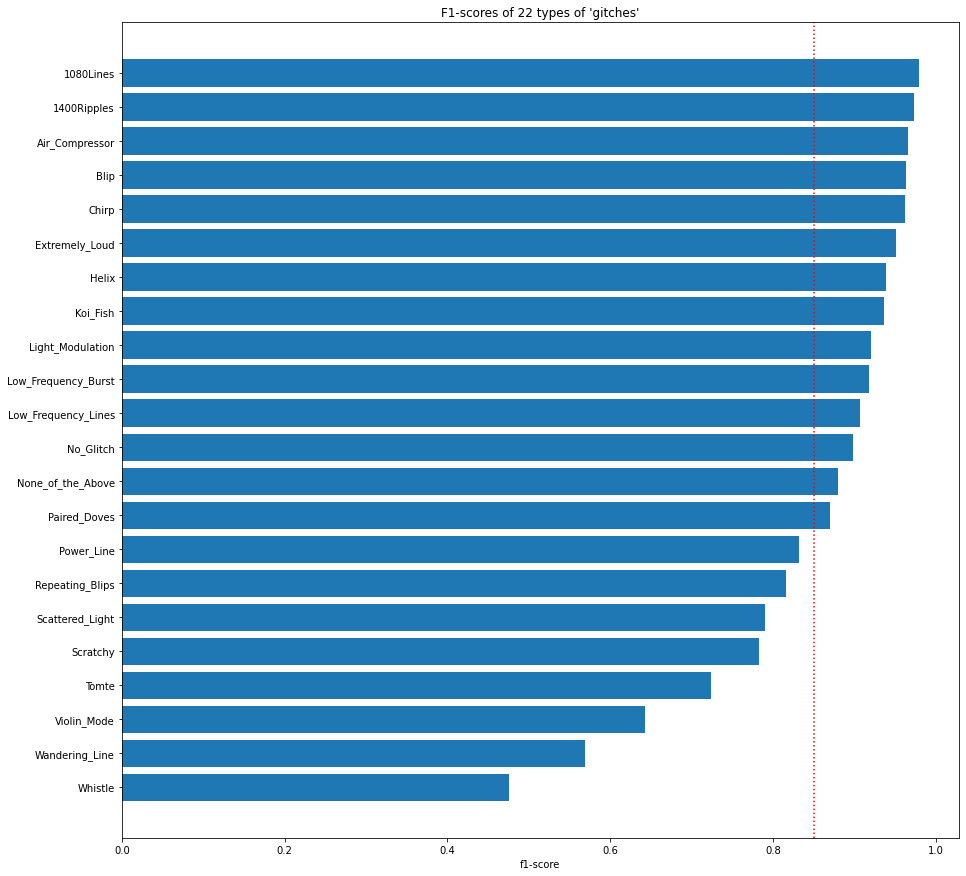

In [112]:
# Plot the horizontal bar chart 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
scores = ax.barh(range(len(df_f1_score)), df_f1_score["f1_score"])
ax.set_yticks(range(len(df_f1_score)))
ax.set_yticklabels(class_names)
ax.set_xlabel("f1-score")
ax.set_title("F1-scores of 22 types of 'gitches'")
plt.axvline(x=0.85, ls='dotted', c='r')
ax.invert_yaxis();

# Visualize the model's prediction on test data

In [113]:
# Prepare images to load into the model

def prep_testimgs(filename, 
                 img_shape=224, 
                 scale=True):
    img = tf.io.read_file(filename)
    img = tf.io.decode_image(img)
    img = tf.image.resize(img, [img_shape, img_shape])
    img = img[:, :, :3] # Converting the image size from (224, 224, 4) due to alpha channel to (224, 224, 3). 
    # From here: (https://stackoverflow.com/questions/35902302/discarding-alpha-channel-from-images-stored-as-numpy-arrays)
    if scale:
        return img/255.
    return img

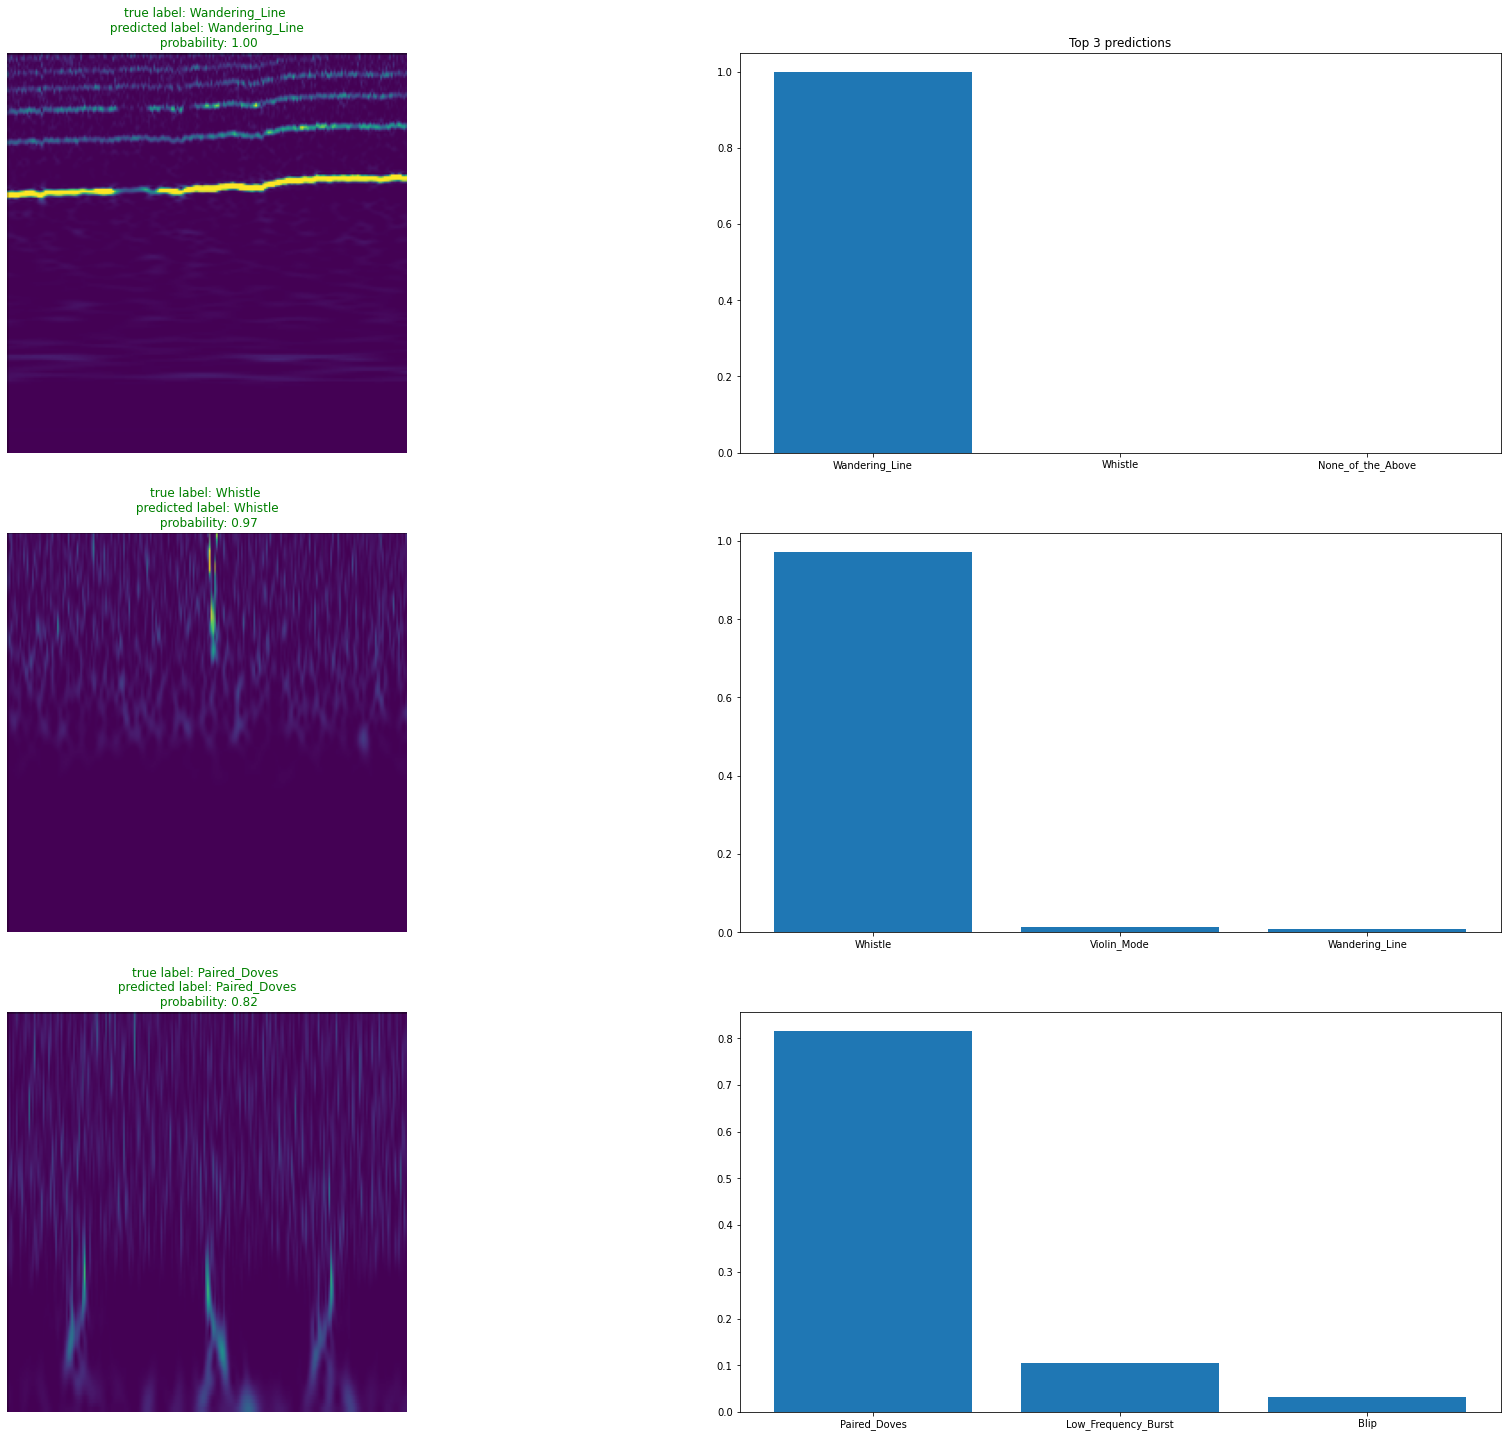

In [239]:
# Select 1 random image from different class and make prediction

import os
import random

num_plots = 3
fig, axs = plt.subplots(num_plots, 2, figsize=(30, 25))
for i in range(num_plots):
    
    # Get the random image file path
    random_class_name = random.choice(class_names)
    random_file = random.choice(os.listdir(test_dir + "/" + random_class_name))
    filepath = test_dir + random_class_name + "/" + random_file
    
    # Image preprocessing before it is fed inside model for prediction
    # Remember the model already has image rescaling layer built in so we don't need to rescale it
    img = tf.io.read_file(filepath)
    img = tf.io.decode_image(img)
    img = tf.image.resize(img, [224, 224])
    img = img[:, :, :3]
    img = tf.expand_dims(img, axis=0)
    
    # Predict the image using the model we built
    pred_prob_image = model.predict(img)
    pred_class_image = class_names[pred_prob_image.argmax()]
    
    top_3_pred_prob_idx = (pred_prob_image.argsort())[0][-3:][::-1]
    top_3_pred_prob = [pred_prob_image[0][idx1] for idx1 in top_3_pred_prob_idx]
    top_3_pred_class = [class_names[idx2] for idx2 in top_3_pred_prob_idx]
    
    # Plot the figure
    # We need to remove that extra dimension related to the batch and divide the pixels by 255. for imshow() function
    axs[i, 0].imshow(tf.squeeze(img/255.))
    if random_class_name == pred_class_image:
        title_color = 'g'
    else:
        title_color = 'r'
    axs[i, 0].set_title(f"true label: {random_class_name} \n predicted label: {pred_class_image} \n probability: {pred_prob_image.max():.2f}", 
                     c=title_color)
    axs[i, 0].axis(False)
    
    axs[0, 1].set_title("Top 3 predictions")
    axs[i, 1].bar(top_3_pred_class, top_3_pred_prob);